# Supervised Learning: Desicion Trees 

## Case Study: Predicting housing prices in Iowa

In this notebook we will analyse the **Ames Housing Dataset**. This data set describes the sale of individual residential property in Ames, Iowa from 2006 to 2010. The data set contains 2930 observations and a large number of explanatory variables (23 nominal, 23 ordinal, 14 discrete, and 20 continuous) involved in assessing home values.

For more information about the Data Set see: https://www.kaggle.com/c/house-prices-advanced-regression-techniques

### 1. Importing the necessary packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# The sklearn.tree module includes decision tree-based models for classification and regression.
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
%matplotlib inline

### 2. Reading Data

In [2]:
# Read the necessary files from a csv, use first column as index
data = pd.read_csv('../../../Data/iowa_housing.csv', index_col=0)
# print the first 5 rows of the data
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
print("Shape of the data:" ,data.shape)

Shape of the data: (1460, 80)


We can observe a some NaN (not a number) values in some of the columns an also a lot of columns. Thus, special precaution should be taken not to be affected by the dimentionality problem. There are 1460 rows and 80 columns in the data

### 3. Data Exploration and selection

Since there are plenty of columns, for this project we will consider the columns with the highest correlation to the feature **SalePrice**. Let's take the features greater than 0.5 with respect to SalePrice:

In [4]:
# Use the method ".corr()" to calculate the correlation of the numerical features and take those of "salePrice"
corr = data.corr()['SalePrice'].sort_values(ascending=False)
corr.head(10)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64

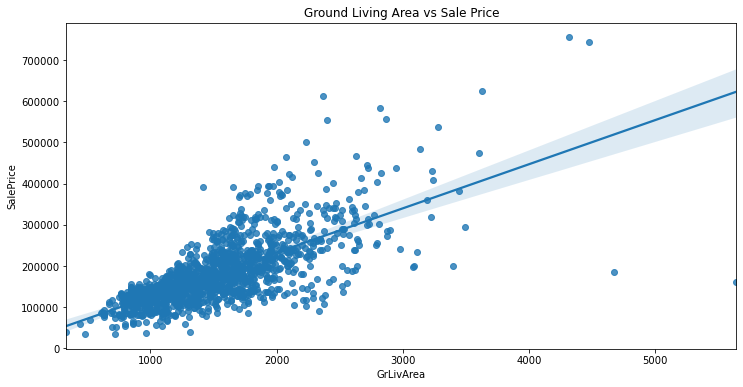

In [5]:
# Take only the higly correlated
correlated_columns = corr[abs(corr)>.5].index.values[1:]

# One of the most higly correlated columns is "GrLivArea". let us inspect that variable with a regression plot
fig = plt.figure(figsize=(12,6))
sns.regplot(data.GrLivArea, data.SalePrice).set_title('Ground Living Area vs Sale Price');

The data has many columns that include only categorical Data. This data can not be fed directly to the model so we must first encode it in a format that can be teached to the tree.

In [6]:
data.dtypes[data.dtypes == object].head()

MSZoning       object
Street         object
Alley          object
LotShape       object
LandContour    object
dtype: object

In [7]:
# print the Different values in the column "SaleCondition" and the times they occur
data['SaleCondition'].value_counts()

Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: SaleCondition, dtype: int64

In [8]:
# To simplify the analysis we will only use the following columns to train our model
categorical_cols = ['Neighborhood', 'Heating', 'ExterCond']

### 4. Data preprocessing and preparation

The first step is to convert the categorical variables into numerical variables. For this we will use a technique known as **one hot encoding** in which we wil create a column for each of the possible values of each column:

In [9]:
one_hot_columns = pd.get_dummies(data[categorical_cols])
one_hot_columns.head()

,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,...,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA
Id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


We have to be careful when using _one hot encoding_ since the number of coulumns can quialy grow and become a problem.

#### Separate the data into predictors and target variables

In [10]:
# Add the numerical and categorical variables
X = pd.concat((data[correlated_columns], one_hot_columns), axis=1)
y = data['SalePrice'].copy()

#### Fill Nan values using the mean of each column for the numerical variables and the mode for categorical variables

In [11]:
X[correlated_columns] = X[correlated_columns].fillna(X[correlated_columns].mean())
X = X.fillna(X.median())

In [12]:
X.head()

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,...,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA
Id,,,,,,,,,,,,,,,,,,,,,
1,7,1710,2,548,856,856,2,8,2003,2003,...,1,0,0,0,0,0,0,0,0,1
2,6,1262,2,460,1262,1262,2,6,1976,1976,...,1,0,0,0,0,0,0,0,0,1
3,7,1786,2,608,920,920,2,6,2001,2002,...,1,0,0,0,0,0,0,0,0,1
4,7,1717,3,642,756,961,1,7,1915,1970,...,1,0,0,0,0,0,0,0,0,1
5,8,2198,3,836,1145,1145,2,9,2000,2000,...,1,0,0,0,0,0,0,0,0,1


### 5. Constructing the tree

For this exaple we will work with a Random Forest Regressor:

A random forest is a meta estimator that fits a number of classifying decision trees on various **sub-samples** of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is controlled with the `max_samples` parameter if `bootstrap=True` (default), otherwise the whole dataset is used to build each tree.


For more information about the implementation see: 

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [13]:
# Initialize the classifier, we will keep the default parameters for now
model = RandomForestRegressor()

#### Fit the data to the model

In [14]:
# Fit the tree to the data
model.fit(X,y);

### 6. Use the model to make predictions

With the model trained, we can now predict the price of a given house in Iowa

In [15]:
# Lets choose a data point
test_house = X.iloc[42]
test_house[test_house != 0]

OverallQual                5
GrLivArea                884
GarageCars                 2
GarageArea               504
TotalBsmtSF              840
1stFlrSF                 884
FullBath                   1
TotRmsAbvGrd               5
YearBuilt               1983
YearRemodAdd            1983
Neighborhood_SawyerW       1
Heating_GasA               1
ExterCond_TA               1
Name: 43, dtype: int64

Generally, we can se that this house has 1 full bathroom, a garage that can fit 2 cars, a basement of 840 sf, is located in the Sawyer West neighborhood, etc. Lets predict its price with our model

#### Comparing the real price vs the estimated price

In [30]:
# create a new point
x_test = test_house.values.reshape(1,-1)

houseprice = model.predict(x_test)[0]


print("The price predicted by the model for the test house is %.0f USD \
while the real price of the house is %.0f USD" % (houseprice, y.iloc[42]))



The price predicted by the model for the test house is 140358 USD while the real price of the house is 144000 USD


Our model is not perfect and there are still some errors in our prediction and possible overfitting

This could perhaps be improve by including more variables and ading some more sofisticated forms of data engineering. We will leave it like this for now.